In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import utils.extract_df as extract_df
import utils.transform as transform
import utils.clustering as clustering
import utils.Feature_Engineering as Feature_Engineering
import utils.model as model

In [2]:
    # extract taxi_data.csv
    filepathcsv = "data/taxi_data.csv"
    df = extract_df.readcsv(filepathcsv)

    # extract nyc.shp
    filepathshp ="data/nyc-boundaries/geo_export_9ca5396d-336c-47af-9742-ab30cd995e41.shp"
    nyc = extract_df.readshp(filepathshp)

    # transform & data cleaning
    transformer = transform.dataTransformation(df,nyc)
    transformedDf = transformer.transform()

    # feature engineering
    filepathtemp = "data/NYC_Weather_2014_2020.csv"
    temperature_df = extract_df.readcsv(filepathtemp)
    merged_df = Feature_Engineering.add_temperature(transformedDf, temperature_df)

    # clustering
    cluster = clustering.pickUpCluster(merged_df)
    df = cluster.clusterCreated()
   

In [3]:
df.head()

,dropoff_latitude,dropoff_longitude,fare_amount,feat01,feat02,feat03,feat04,feat05,feat06,feat07,...,passenger_big_group,fare_amount_log,year,month,day,hour,trip_distance,date,avg_temperature_2m (°C),pickup_cluster
0,40.768550,-73.862065,52.713,0.607633,0.680994,0.869333,0.359081,0.283538,0.898003,0.481185,...,1,3.964862,2014,1,8,6,10.461512,2014-01-08,2.366667,0
1,40.746906,-73.990494,19.350,0.353808,0.555256,0.946294,0.530530,0.453938,0.708570,0.161038,...,0,2.962692,2015,2,16,20,2.089068,2015-02-16,1.312500,0
2,40.697496,-73.984946,24.850,0.248761,0.271752,0.418165,0.368993,0.362234,0.257532,0.710595,...,0,3.212858,2014,3,18,13,2.590397,2014-03-18,10.420833,5
3,40.767617,-73.959482,16.600,0.606718,0.809065,0.826723,0.228102,0.819767,0.859372,0.014095,...,0,2.809403,2014,3,20,18,1.402666,2014-03-20,3.391667,2
4,40.724657,-73.994457,14.950,0.386871,0.657538,0.861953,0.155679,0.928781,0.935444,0.381414,...,0,2.704711,2014,4,10,22,1.059340,2014-04-10,4.308333,4


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88175 entries, 0 to 88174
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   dropoff_latitude         88175 non-null  float64            
 1   dropoff_longitude        88175 non-null  float64            
 2   fare_amount              88175 non-null  float64            
 3   feat01                   88175 non-null  float64            
 4   feat02                   88175 non-null  float64            
 5   feat03                   88175 non-null  float64            
 6   feat04                   88175 non-null  float64            
 7   feat05                   88175 non-null  float64            
 8   feat06                   88175 non-null  float64            
 9   feat07                   88175 non-null  float64            
 10  feat08                   88175 non-null  float64            
 11  feat09                   881

In [18]:
df.to_pickle('../model/clean_data/clustered_data.pkl')

In [31]:
# drop datetime column
df_modelling = df.drop(columns=['pickup_datetime','date'], inplace=False)
# model filepahts
model_RF_path = "data/models/RF_model.pkl"
model_RF_log_path = "data/models/RF_model_log.pkl"
# define models
RF = model.Model(model_RF_path, df_modelling, 'fare_amount')
RF_log = model.Model(model_RF_log_path, df_modelling, 'fare_amount_log')
# fit models
RF.load_model()
RF.prepare_data()
RF.fit_model()
RF_log.load_model()
RF_log.prepare_data()
RF_log.fit_model()
# predict
# TODO just for prints
print(RF.predict(RF.X_test))
print(RF_log.predict(RF_log.X_test))
# train score
print(RF.train_score())
print(RF_log.train_score())
# test score
print(RF.test_score())
print(RF_log.test_score())

Index(['dropoff_latitude', 'dropoff_longitude', 'fare_amount', 'feat01',
       'feat02', 'feat03', 'feat04', 'feat05', 'feat06', 'feat07', 'feat08',
       'feat09', 'feat10', 'passenger_count', 'pickup_latitude',
       'pickup_longitude', 'passenger_big_group', 'fare_amount_log', 'year',
       'month', 'day', 'hour', 'trip_distance', 'avg_temperature_2m (°C)',
       'pickup_cluster'],
      dtype='object')
[20.85363511 23.8222348  21.71012371 ... 20.75213746 21.05229448
 20.68174993]
[3.00655911 3.17216993 3.05602114 ... 2.963709   3.01219043 2.9586797 ]
6.83438834522334
0.21028657966115855
7.814116082851834
0.21286192818131097


In [3]:
import shap
df_modelling = df.drop(columns=['pickup_datetime','date'], inplace=False)
# One hot encode passenger_big_group, pickup_cluster
df_modelling = pd.get_dummies(df_modelling, columns=['passenger_big_group','pickup_cluster'])
# model filepahts
model_XGB_path = "data/models/XGB_model.pkl"
# XGB = joblib.load(model_XGB_path)
# XGB.fit()
# define models
XGB = model.Model(model_XGB_path, df_modelling, 'fare_amount')
# fit models
XGB.load_model()
XGB.prepare_data()
XGB = XGB.fit_model()
explainer = shap.Explainer(XGB)
print(df_modelling.drop(['fare_amount','fare_amount_log'],axis=1).columns)
# display(df_modelling.drop(['fare_amount'],axis=1).iloc[:26452500])
shap_values = explainer(df_modelling.drop(['fare_amount', 'fare_amount_log'],axis=1))
# visualize the first prediction's explanation with a force plot
shap.plots.force(shap_values[0])

c:\Users\jakub\OneDrive\Documents\DSBA_OneDrive\4sem\Reproducible-Research-Project\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Index(['dropoff_latitude', 'dropoff_longitude', 'feat01', 'feat02', 'feat03',
       'feat04', 'feat05', 'feat06', 'feat07', 'feat08', 'feat09', 'feat10',
       'passenger_count', 'pickup_latitude', 'pickup_longitude', 'year',
       'month', 'day', 'hour', 'trip_distance', 'avg_temperature_2m (°C)',
       'passenger_big_group_0', 'passenger_big_group_1', 'pickup_cluster_0',
       'pickup_cluster_1', 'pickup_cluster_2', 'pickup_cluster_3',
       'pickup_cluster_4', 'pickup_cluster_5'],
      dtype='object')


ImportError: matplotlib is not installed so plotting is not available! Run `pip install matplotlib` to fix this.

In [6]:
import pickle
with open(r"data/models/shap_values_XGB.pkl", "wb") as output_file:
     pickle.dump(shap_values, output_file)


In [3]:
import pickle
with open(r"data/models/shap_values_XGB.pkl", "rb") as input_file:
    shap_values_pkl = pickle.load(input_file)

c:\Users\jakub\OneDrive\Documents\DSBA_OneDrive\4sem\Reproducible-Research-Project\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
import shap
shap.plots.initjs()
shap.plots.force(shap_values_pkl[0])

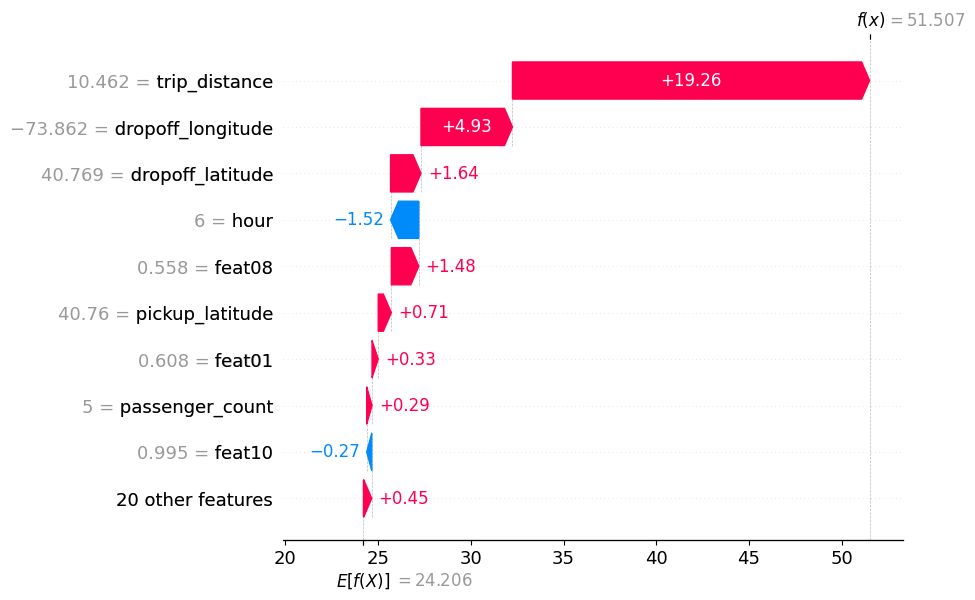

In [7]:
shap.plots.waterfall(shap_values_pkl[0])

In [ ]:
# param_grid = {
#         'n_estimators': [100, 200],
#         'max_features': [1.0, 'sqrt', 'log2'],
#         'max_depth' : [4,8],
#         'min_samples_split': [2],
#     }
param_grid = {
    'n_estimators': [1000], #Irena 1000
    'max_features': [1.0,'sqrt'], #Irena tuned this one
    'max_depth' : [8],
    'min_samples_split': [2,4,8], #Irena tuned this one
}

## Run the application

In [23]:
! streamlit run 1_Homepage.py


  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://192.168.1.13:8501

  For better performance, install the Watchdog module:

  $ xcode-select --install
  $ pip install watchdog
            
2024-06-02 22:49:14.270 `st.cache` is deprecated. Please use one of Streamlit's new caching commands,
`st.cache_data` or `st.cache_resource`.

More information [in our docs](https://docs.streamlit.io/library/advanced-features/caching).
^C
  Stopping...
